# Liveify Model Loading and Testing
Load a trained model and test it on audio samples.

In [1]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

sys.path.insert(0, '../')

from model import LiveifyModel
from dataset.dataset import StudioLiveDataModule

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = "cpu"
print(f"Using device: {device}")

/home/vedpatel/.conda/envs/pyml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


## Load Model Checkpoint

In [2]:
CHECKPOINT_PATH = "../../checkpoints/best-v6.ckpt"
SAMPLE_RATE = 22050
SEGMENT_DURATION = 0.02  # 20ms segments

model = LiveifyModel(
    input_sr=int(SAMPLE_RATE * SEGMENT_DURATION),  # 441 samples
    output_sr=int(SAMPLE_RATE * SEGMENT_DURATION),
    hidden_channels=128,
    encoder_strides=[4, 4, 2],
    transformer_dim=512,
    num_heads=8,
    num_layers=4,
    lstm_hidden=256,
    lr=3.5e-6,
).to(device)

print(f"Model created with input size: {int(SAMPLE_RATE * SEGMENT_DURATION)} samples")

if os.path.exists(CHECKPOINT_PATH):
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
    
    if 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
        state_dict = {k.replace('model.', ''): v for k, v in state_dict.items()}
        model.load_state_dict(state_dict)
    else:
        model.load_state_dict(checkpoint)
    
    print(f"✓ Loaded checkpoint from: {CHECKPOINT_PATH}")
else:
    print(f"⚠ Warning: Checkpoint not found at {CHECKPOINT_PATH}")
    print("  Using random initialization. Train the model first.")

model.eval()

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")

Model created with input size: 441 samples
✓ Loaded checkpoint from: ../../checkpoints/best-v6.ckpt

Model parameters:
  Total: 20,610,313
  Trainable: 20,610,313


/mnt/Fedora2/code/Liveify/src/notebooks/../model.py:111: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)


## Load Test Data

In [3]:
datamodule = StudioLiveDataModule(
    studio_dir="../../dataset/studio",
    live_dir="../../dataset/live",
    batch_size=4,
    sr=SAMPLE_RATE,
    segment_duration=SEGMENT_DURATION,
    num_workers=0,
    development_mode=True,
)

datamodule.setup()
val_loader = datamodule.val_dataloader()

print(f"✓ Loaded validation dataset")
print(f"  Batch size: 4")
print(f"  Sample rate: {SAMPLE_RATE} Hz")
print(f"  Segment duration: {SEGMENT_DURATION}s")

Loading segments from cache: ./cache/segments_d0d8f7bf84c6e7dd37a2cce7ca098a96.pkl
Loaded 9500 segments from cache
Dataset split: 7600 train, 1900 val
✓ Loaded validation dataset
  Batch size: 4
  Sample rate: 22050 Hz
  Segment duration: 0.02s


## Run Inference on Test Batch

In [4]:
studio_audio, live_audio = next(iter(val_loader))
studio_audio = studio_audio.to(device)
live_audio = live_audio.to(device)

print(f"Input batch shapes:")
print(f"  Studio (input): {studio_audio.shape}")
print(f"  Live (target): {live_audio.shape}")

with torch.no_grad():
    output = model(studio_audio)

print(f"\nOutput shape: {output.shape}")

l1_loss = torch.nn.functional.l1_loss(output, live_audio).item()
mse_loss = torch.nn.functional.mse_loss(output, live_audio).item()

print(f"\nInference metrics:")
print(f"  L1 Loss: {l1_loss:.6f}")
print(f"  MSE Loss: {mse_loss:.6f}")

Input batch shapes:
  Studio (input): torch.Size([4, 441])
  Live (target): torch.Size([4, 441])

Output shape: torch.Size([4, 441])

Inference metrics:
  L1 Loss: 0.401613
  MSE Loss: 0.252352


## Visualize Results

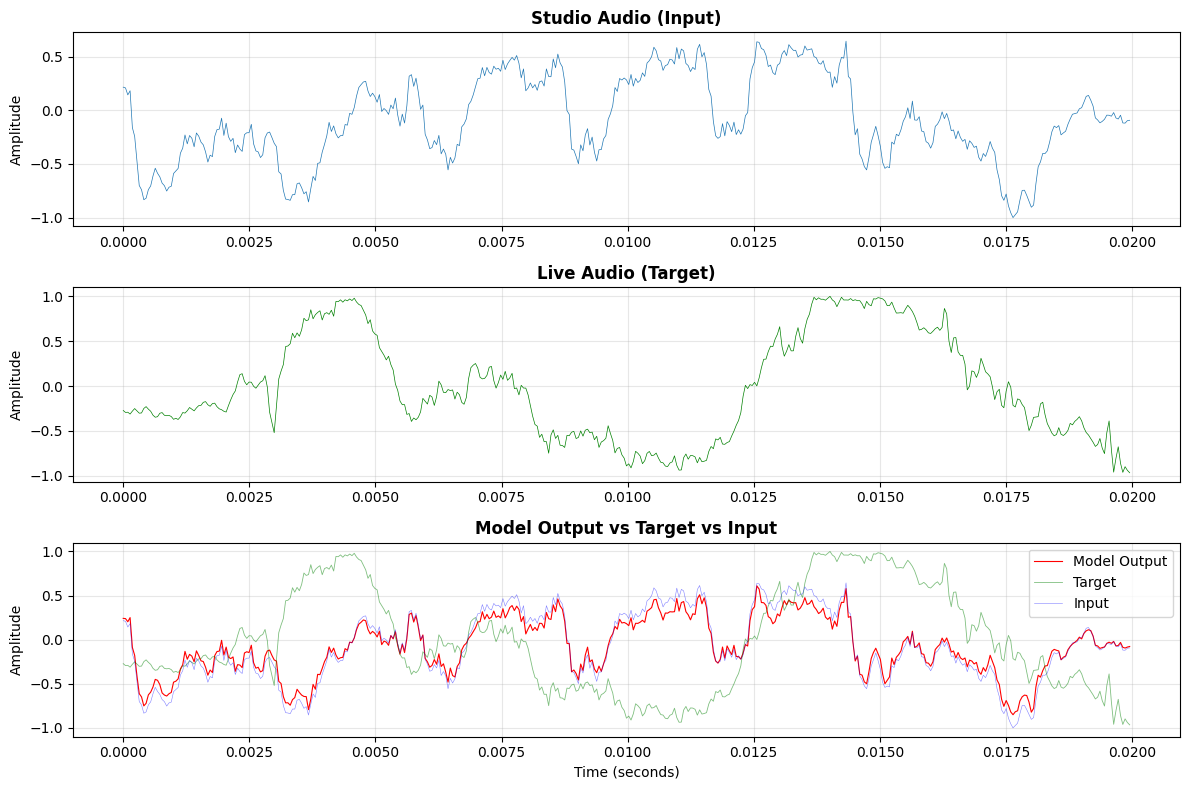

✓ Visualization saved to inference_results.png


In [5]:
sample_idx = 0
studio_np = studio_audio[sample_idx].cpu().numpy()
live_np = live_audio[sample_idx].cpu().numpy()
output_np = output[sample_idx].cpu().numpy()

fig, axes = plt.subplots(3, 1, figsize=(12, 8))
time_axis = np.arange(len(studio_np)) / SAMPLE_RATE

axes[0].plot(time_axis, studio_np, linewidth=0.5)
axes[0].set_title(f'Studio Audio (Input)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Amplitude')
axes[0].grid(True, alpha=0.3)

axes[1].plot(time_axis, live_np, linewidth=0.5, color='green')
axes[1].set_title(f'Live Audio (Target)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Amplitude')
axes[1].grid(True, alpha=0.3)

axes[2].plot(time_axis, output_np, linewidth=0.8, color='red', label='Model Output')
axes[2].plot(time_axis, live_np, linewidth=0.6, color='green', alpha=0.5, label='Target')
axes[2].plot(time_axis, studio_np, linewidth=0.4, color='blue', alpha=0.5, label='Input')
axes[2].set_title(f'Model Output vs Target vs Input', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Time (seconds)')
axes[2].set_ylabel('Amplitude')
axes[2].legend()
axes[2].grid(True, alpha=0.3)


plt.tight_layout()
plt.savefig('inference_results.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Visualization saved to inference_results.png")

In [11]:
from IPython.display import display, Audio

print("Studio Audio (Input):")
display(Audio(studio_np, rate=SAMPLE_RATE))

print("Model Output:")
display(Audio(output_np, rate=SAMPLE_RATE))

print("Live Audio (Target):")
display(Audio(live_np, rate=SAMPLE_RATE))

Studio Audio (Input):


Model Output:


Live Audio (Target):


## Batch Processing Results

In [6]:
batch_size = studio_audio.shape[0]

print(f"Per-sample metrics (batch of {batch_size}):")
print(f"{'Sample':<8} {'L1 Loss':<12} {'MSE Loss':<12}")
print("-" * 32)

for i in range(batch_size):
    l1 = torch.nn.functional.l1_loss(output[i], live_audio[i]).item()
    mse = torch.nn.functional.mse_loss(output[i], live_audio[i]).item()
    print(f"{i:<8} {l1:<12.6f} {mse:<12.6f}")

print("-" * 32)
print(f"{'Mean':<8} {l1_loss:<12.6f} {mse_loss:<12.6f}")

Per-sample metrics (batch of 4):
Sample   L1 Loss      MSE Loss    
--------------------------------
0        0.553957     0.458987    
1        0.384806     0.221232    
2        0.309312     0.136204    
3        0.358379     0.192985    
--------------------------------
Mean     0.401613     0.252352    


## Test on Full Validation Set

In [7]:
all_l1_losses = []
all_mse_losses = []

with torch.no_grad():
    for batch_idx, (studio, live) in enumerate(val_loader):
        studio = studio.to(device)
        live = live.to(device)
        
        output = model(studio)
        
        l1 = torch.nn.functional.l1_loss(output, live).item()
        mse = torch.nn.functional.mse_loss(output, live).item()
        
        all_l1_losses.append(l1)
        all_mse_losses.append(mse)

mean_l1 = np.mean(all_l1_losses)
mean_mse = np.mean(all_mse_losses)
std_l1 = np.std(all_l1_losses)
std_mse = np.std(all_mse_losses)

print(f"Validation Set Results (all {len(all_l1_losses)} batches):")
print(f"  L1 Loss:  {mean_l1:.6f} ± {std_l1:.6f}")
print(f"  MSE Loss: {mean_mse:.6f} ± {std_mse:.6f}")

Validation Set Results (all 475 batches):
  L1 Loss:  0.385537 ± 0.048783
  MSE Loss: 0.235593 ± 0.055905


# Full Song Processing
Process an entire song using the loaded model with sliding windows.

In [8]:
import librosa
import soundfile as sf
import IPython.display as ipd
from tqdm import tqdm
from scipy.signal.windows import hann

def process_full_song_with_loaded_model(model, audio_path, segment_duration=None, sr=None, overlap=0.01):
    """
    Process an entire song with the already loaded model using sliding windows.
    Uses the model's existing segment duration and sample rate.
    
    Args:
        model: Already loaded LiveifyModel 
        audio_path: Path to input audio file
        segment_duration: Duration override (uses model's SEGMENT_DURATION if None)
        sr: Sample rate override (uses model's SAMPLE_RATE if None) 
        overlap: Overlap between segments (0.01s = 10ms for small segments)
    
    Returns:
        processed_audio: Full processed audio array
        original_audio: Original audio for comparison
    """
    segment_duration = segment_duration or SEGMENT_DURATION
    sr = sr or SAMPLE_RATE
    
    audio, _ = librosa.load(audio_path, sr=sr)
    print(f"Loaded audio: {len(audio)/sr:.2f} seconds")
    
    segment_samples = int(segment_duration * sr)  
    overlap_samples = int(overlap * sr)           
    step_size = segment_samples - overlap_samples 
    
    print(f"Using loaded model parameters:")
    print(f"  Segment length: {segment_samples} samples ({segment_duration}s)")
    print(f"  Overlap: {overlap_samples} samples ({overlap}s)")
    print(f"  Step size: {step_size} samples")
    
    num_segments = (len(audio) - segment_samples) // step_size + 1
    print(f"Processing {num_segments} segments...")
    
    processed_audio = np.zeros_like(audio)
    weight_sum = np.zeros_like(audio)  
    
    window = hann(segment_samples) if segment_samples > 1 else np.ones(segment_samples)
    
    model.eval()
    with torch.no_grad():
        for i in tqdm(range(num_segments), desc="Processing segments"):
            start_idx = i * step_size
            end_idx = start_idx + segment_samples
            
            if end_idx > len(audio):
                segment = audio[start_idx:]
                if len(segment) < segment_samples:
                    segment = np.pad(segment, (0, segment_samples - len(segment)))
            else:
                segment = audio[start_idx:end_idx]
            
            max_val = np.max(np.abs(segment))
            if max_val > 1e-7:
                segment_norm = segment / max_val
            else:
                segment_norm = segment
            
            segment_tensor = torch.from_numpy(segment_norm).float().unsqueeze(0).to(device)
            
            processed_segment = model(segment_tensor)
            processed_segment = processed_segment.squeeze(0).cpu().numpy()
            
            if max_val > 1e-7:
                processed_segment = processed_segment * max_val
            
            windowed_segment = processed_segment * window
            
            if end_idx <= len(audio):
                processed_audio[start_idx:end_idx] += windowed_segment
                weight_sum[start_idx:end_idx] += window
            else:
                actual_end = len(audio)
                actual_length = actual_end - start_idx
                processed_audio[start_idx:actual_end] += windowed_segment[:actual_length]
                weight_sum[start_idx:actual_end] += window[:actual_length]
    
    mask = weight_sum > 1e-8
    processed_audio[mask] /= weight_sum[mask]
    
    return processed_audio, audio

print("✓ Full song processing function defined using loaded model parameters")

✓ Full song processing function defined using loaded model parameters


In [9]:
studio_dir = Path("../../dataset/studio")
available_files = list(studio_dir.glob("*.wav")) + list(studio_dir.glob("*.mp3"))

print("Available studio recordings:")
for i, file_path in enumerate(available_files):
    duration = librosa.get_duration(path=file_path)
    print(f"{i}: {file_path.name} ({duration:.1f}s)")

if available_files:
    selected_file = available_files[0] 
    print(f"\n🎵 Selected: {selected_file.name}")
else:
    print("❌ No audio files found in studio directory")
    selected_file = None

Available studio recordings:
0: Alone Again.mp3 (251.1s)
1: Gasoline.mp3 (211.6s)
2: Sacrifice.mp3 (188.4s)
3: Heartless.mp3 (201.2s)
4: Party Monster.mp3 (249.3s)
5: Faith.mp3 (284.3s)
6: After Hours.mp3 (361.9s)
7: Out Of Time.mp3 (214.3s)
8: Save Your Tears.mp3 (216.6s)
9: Less Than Zero.mp3 (211.9s)
10: Blinding Lights.mp3 (203.2s)
11: Crew Love.mp3 (208.8s)
12: Die For You.mp3 (260.3s)
13: I Was Never There.mp3 (241.1s)
14: Kiss Land.mp3 (455.3s)
15: Low Life.mp3 (313.5s)
16: Often.mp3 (249.1s)
17: The Hills.mp3 (242.3s)
18: Take My Breath.mp3 (339.0s)
19: Wicked Games.mp3 (325.3s)
20: Starboy.mp3 (230.6s)
21: Is There Someone Else.mp3 (199.2s)
22: I Feel It Coming.mp3 (269.3s)
23: Can't Feel My Face.mp3 (215.7s)
24: How Do I Make You Love Me.mp3 (213.7s)

🎵 Selected: Alone Again.mp3


In [10]:
if selected_file:
    print(f"Processing {selected_file.name}...")
    
    processed, original = process_full_song_with_loaded_model(model, selected_file)
    
    output_dir = Path("processed_songs") 
    output_dir.mkdir(exist_ok=True)
    
    base_name = selected_file.stem
    original_path = output_dir / f"{base_name}_original.wav"
    processed_path = output_dir / f"{base_name}_processed.wav"
    
    sf.write(original_path, original, SAMPLE_RATE)
    sf.write(processed_path, processed, SAMPLE_RATE)
    
    print(f"✓ Saved original to: {original_path}")
    print(f"✓ Saved processed to: {processed_path}")
    
    print(f"\nAudio statistics:")
    print(f"  Duration: {len(original)/SAMPLE_RATE:.1f} seconds")
    print(f"  Original RMS: {np.sqrt(np.mean(original**2)):.6f}")
    print(f"  Processed RMS: {np.sqrt(np.mean(processed**2)):.6f}")
    print(f"  Difference RMS: {np.sqrt(np.mean((processed - original)**2)):.6f}")
    
else:
    print("❌ No file selected for processing")

Processing Alone Again.mp3...
Loaded audio: 251.10 seconds
Using loaded model parameters:
  Segment length: 441 samples (0.02s)
  Overlap: 220 samples (0.01s)
  Step size: 221 samples
Processing 25052 segments...


Processing segments:   3%|▎         | 744/25052 [00:04<02:36, 155.02it/s]


KeyboardInterrupt: 

In [ ]:
if 'processed' in locals() and 'original' in locals():
    plot_duration = 5 
    plot_samples = plot_duration * SAMPLE_RATE
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 10))
    time_axis = np.arange(plot_samples) / SAMPLE_RATE
    
    axes[0].plot(time_axis, original[:plot_samples], linewidth=0.5, alpha=0.8, color='blue')
    axes[0].set_title(f'Original Studio Audio - {selected_file.name} (first {plot_duration}s)', fontweight='bold')
    axes[0].set_ylabel('Amplitude')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(time_axis, processed[:plot_samples], linewidth=0.5, alpha=0.8, color='red')
    axes[1].set_title(f'Processed "Live" Audio (first {plot_duration}s)', fontweight='bold') 
    axes[1].set_ylabel('Amplitude')
    axes[1].grid(True, alpha=0.3)
    
    axes[2].plot(time_axis, original[:plot_samples], linewidth=0.5, alpha=0.6, color='blue', label='Original')
    axes[2].plot(time_axis, processed[:plot_samples], linewidth=0.5, alpha=0.8, color='red', label='Processed')
    axes[2].set_title(f'Overlay Comparison (first {plot_duration}s)', fontweight='bold')
    axes[2].set_xlabel('Time (seconds)')
    axes[2].set_ylabel('Amplitude') 
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Waveform comparison plotted")
else:
    print("❌ No processed audio to visualize")

In [ ]:
if 'original_path' in locals() and 'processed_path' in locals():
    print("🎵 ORIGINAL Studio Audio:")
    display(ipd.Audio(str(original_path)))
    
    print("\n🎵 PROCESSED 'Live' Audio:") 
    display(ipd.Audio(str(processed_path)))
    
    print(f"\n📁 Files saved in: {output_dir.absolute()}")
else:
    print("❌ No audio files to play")